In [1]:
import tensorflow as tf
import visual_data_explanation as vde
from gridworld import GridworldMdp
from utils import plot_trajectory, plot_reward, plot_reward_and_trajectories
from fast_agents import FastOptimalAgent
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

/Users/ngundotra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
graph = tf.Graph()
export_dir = 'model_save'
sess = tf.Session(graph=graph)
tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)

INFO:tensorflow:Restoring parameters from model_save/variables/variables


meta_info_def {
  stripped_op_list {
    op {
      name: "Add"
      input_arg {
        name: "x"
        type_attr: "T"
      }
      input_arg {
        name: "y"
        type_attr: "T"
      }
      output_arg {
        name: "z"
        type_attr: "T"
      }
      attr {
        name: "T"
        type: "type"
        allowed_values {
          list {
            type: DT_BFLOAT16
            type: DT_HALF
            type: DT_FLOAT
            type: DT_DOUBLE
            type: DT_UINT8
            type: DT_INT8
            type: DT_INT16
            type: DT_INT32
            type: DT_INT64
            type: DT_COMPLEX64
            type: DT_COMPLEX128
            type: DT_STRING
          }
        }
      }
    }
    op {
      name: "AddN"
      input_arg {
        name: "inputs"
        type_attr: "T"
        number_attr: "N"
      }
      output_arg {
        name: "sum"
        type_attr: "T"
      }
      attr {
        name: "N"
        type: "int"
        has_minimum: t

In [3]:
vtensors = set()
for op in graph.get_operations():
    if 'v_' in op.name and 'grad' not in op.name and '/' not in op.name:
        vtensors.add(op)

# Find the last value map
sortable_vtensors = []
greatest = None
greatestnum = 1
for op in vtensors:
    opname = op.name.split('/')[0]
    opnum = int(opname[2:])
    sortable_vtensors.append((opnum, op))
    if opnum > greatestnum:
        greatest = op
        greatestnum = opnum
    
print(greatest)

name: "v_19"
op: "Max"
input: "q_19"
input: "v_19/reduction_indices"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
attr {
  key: "keep_dims"
  value {
    b: true
  }
}



In [5]:
grids = vde.grids

In [6]:
mdp = GridworldMdp(grids[2])

In [7]:
walls, reward, start = mdp.convert_to_numpy_input()

In [8]:
def repeat_vector(walls, reward, num=20):
    w = np.stack([walls] * 20)
    r = np.stack([reward] * 20)
    return w, r
w, r = repeat_vector(walls, reward)

In [7]:
for op in graph.get_operations():
    if 'v_' in op.name and 'grad' not in op.name:
        print(op)
    if "output" in op.name:
        print(op.name)

name: "v_1/reduction_indices"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
      }
      int_val: 3
    }
  }
}

name: "v_1"
op: "Max"
input: "q_1"
input: "v_1/reduction_indices"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
attr {
  key: "keep_dims"
  value {
    b: true
  }
}

name: "v_2/reduction_indices"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
      }
      int_val: 3
    }
  }
}

name: "v_2"
op: "Max"
input: "q_2"
input: "v_2/reduction_indices"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
attr {
  key: "keep_dims"
  value {
    b: true
  }
}

name: "v_3/reduction_indices"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT

In [8]:
# Last value maps
rvs = graph.get_operation_by_name("v_9")
rvs = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=rvs.outputs)
rvs = rvs[0][0].squeeze()
rvs.shape

(8, 8)

In [9]:
oo = graph.get_operation_by_name('output')

In [10]:
oo.outputs

[<tf.Tensor 'output:0' shape=(1280, 5) dtype=float32>]

In [11]:
values = np.max(qs, axis=-1)
values = np.reshape(values, (20, 8, 8))
val = values[0]

NameError: name 'qs' is not defined

In [9]:
def normalize(vals):
    vals = vals - vals.mean()
    vals = vals / (vals.max() - vals.min())
    return vals

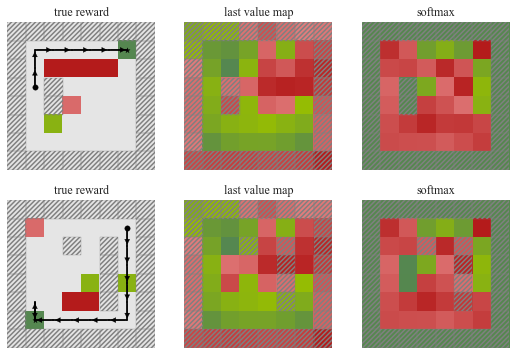

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for ax, gr in zip(axes, grids[2:4]):
    walls, reward, start = GridworldMdp(gr).convert_to_numpy_input()
    
    # plotting softmax output of VIN (last layer)
    oo = graph.get_operation_by_name('output')
    qs = sess.run(feed_dict={'image:0': w, 'reward:0': r}, fetches=oo.outputs)[0]
    values = np.max(qs, axis=-1)
    val = np.reshape(values, (20, 8, 8))[0]
    plot_reward(normalize(val), walls, "softmax", fig, ax[2])
    # plotting actual reward
    agent = FastOptimalAgent(beta=1.0)
    plot_trajectory(walls, reward, start, agent, fig, ax[0])
    plot_reward(reward, walls, "true reward", fig, ax[0])
    # plotting last value map of VIN (last VIN block)
    rvs = greatest
    rvs = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=rvs.outputs)
    rvs = rvs[0][0].squeeze()
    plot_reward(normalize(rvs), walls, 'last value map', fig, ax[1])
    
fig.savefig("testing_value_maps.jpg")

In [12]:
sorted_vtensors = list(sorted(sortable_vtensors))
sorted_vtensors

[(1, <tf.Operation 'v_1' type=Max>),
 (2, <tf.Operation 'v_2' type=Max>),
 (3, <tf.Operation 'v_3' type=Max>),
 (4, <tf.Operation 'v_4' type=Max>),
 (5, <tf.Operation 'v_5' type=Max>),
 (6, <tf.Operation 'v_6' type=Max>),
 (7, <tf.Operation 'v_7' type=Max>),
 (8, <tf.Operation 'v_8' type=Max>),
 (9, <tf.Operation 'v_9' type=Max>),
 (10, <tf.Operation 'v_10' type=Max>),
 (11, <tf.Operation 'v_11' type=Max>),
 (12, <tf.Operation 'v_12' type=Max>),
 (13, <tf.Operation 'v_13' type=Max>),
 (14, <tf.Operation 'v_14' type=Max>),
 (15, <tf.Operation 'v_15' type=Max>),
 (16, <tf.Operation 'v_16' type=Max>),
 (17, <tf.Operation 'v_17' type=Max>),
 (18, <tf.Operation 'v_18' type=Max>),
 (19, <tf.Operation 'v_19' type=Max>)]

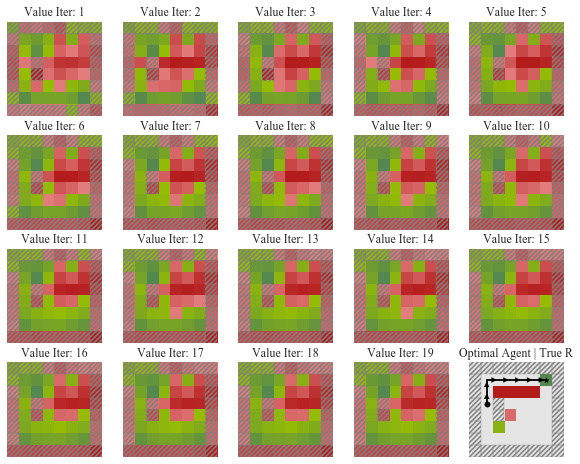

In [17]:
# Comparing value maps. Rows of 5 value maps. Starting from the first
num_cols = 5
num_rows = round(len(sortable_vtensors) // num_cols + 1)
size_scale = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * size_scale, num_rows * size_scale))


gr = grids[2] # or choose grid 3
walls, reward, start = GridworldMdp(gr).convert_to_numpy_input()
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        idx = 5 * i + j
        if idx >= len(sortable_vtensors):
            # If no more value plots, just plot the trajectory on true reward
            agent = FastOptimalAgent(beta=1.0)
            plot_trajectory(walls, reward, start, agent, fig, ax)
            plot_reward(reward, walls, "Optimal Agent | True R", fig, ax)
        else:
            # Plot value map
            opnum, op = sorted_vtensors[5 * i + j]
            vmap = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=op.outputs)
            vmap = vmap[0][0].squeeze()
            plot_reward(normalize(vmap), walls, 'Value Iter: {}'.format(opnum), fig, ax)
fig.savefig("ValueMapComparison-OptimalAgent-VIN-20.jpg")
            
# Plot rollout of the agent on the actual policy..., compared again with the optimal agent
# Plot rollout on inferred reward as well... 
fig, axes = plt.subplot(1, 3)


In [ ]:
def infer_given_model(model, inputs):